# Laboratory #10 : Vision Transformers

At the end of this laboratory, you would get familiarized with

*   Vision Transformers

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# **Students** (First Name and Last Name)

1. Marc Gonzalez Vidal   
2. Oriol Miró López-Feliu

---

# Vision Transformers

Vision Transformers were introduced by Alexey Dosovitskiy et al. in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Read the ViT paper and answer the below descriptive questions.

*   What are the differences between CNN and Transformers?
*   What is Multi-head self-attention?
*   What is Inductive Bias?

**Solution**

- What are the differences between CNN and Transformers?

They are two different architectures used in deep learning. CNNs are based on the convolutional operator, which is used to apply learned filters to extract useful features, while Transformers are base on the self-attention mechanism. As the paper tells, initially we could think that CNN are better to deal with images rather than Transformers as they don't have the inductive biases that are inherent to CNNs as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data. However when we train Transformers in a large amout of data, they are able to outperform CNNs architectures as the paper shows.

- What is Multi-head self-attention?

As said above, the Multi-head self-attention is the core of Transformer architecture, but before entering on hat is the Multi-head self-attention, we should focus on what is the Attention. An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.[1] Therefore Multi-head self-attention are different head self-attention stacked all together operating in parallel where each head computes its own set of attention weights and outputs that are able to be used as Attention mechanisms. This is somewhat analogous to applying different filters in CNNs, as each head focuses on a different subset of features or relationships (Attention is a completely different thing than convolutional filters, we are doing this analogy only to understand why using Multi-head is usefull, with the idea of using more than one filter).

Reference: [1] Vaswani, Ashish, et al. "Attention Is All You Need." Advances in Neural Information Processing Systems, vol. 30, 2017, pp. 5998–6008. arXiv:1706.03762.


- What is Inductive Bias?

The Inductive Bias refers to the set of properties than some models have, where this properties can be an advantage or a disadvantage depending on the tast that you are trying to solve. For example as previously said CNNs have translation equivariance and locality which can help CNNs to generalize with less training data than the data that requires the training of a Transformer.

*   Explain the model architecture of ViT.

**Solution**

The model architecture of ViT is principaly based on what was purposed on the architecture of the Transformer (Vaswani et al., 2017), but as this architecture was build for NLP applications, it has been adapted to be able to work with images. One of the modifications that has been made is that the input $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ is reshaped into a
sequence of flattened 2D patches $\mathbf{x_p} \in \mathbb{R}^{N \times (P^2 · C)}$ where (H, W) is the resolution of the original
image, C is the number of channels, (P, P) is the resolution of each image patch, and $N = \frac{HW}{P^2}$
is the resulting number of patches, which also serves as the effective input sequence length for the
Transformer. Then the Transformer uses constant latent vector of size D through all of their layers, so the patches are flattened and mapped to D dimensions with a trainable linear projection: $\mathbf{z}_0 = [\mathbf{x}_{\text{class}}; \mathbf{x}_p^1 \mathbf{E}; \mathbf{x}_p^2 \mathbf{E}; \cdots; \mathbf{x}_p^N \mathbf{E}] + \mathbf{E}_{\text{pos}}, \quad \mathbf{E} \in \mathbb{R}^{(P^2 \cdot C) \times D}, \quad \mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}$
Then a learnable embedding is prepended to the sequence of embeded patches, whose state at the output of the Transformer encoder $z_L^0$ serve as the image representation $y = \text{LN}(z_L^0)$. A MLP is attached to $z_L^0$ as a classification head, in pre-training the MLP has one hidden layer, but then in fine-tuning time it has only one single layer. The model also needs position embeddings as Transformers lack an inherent sense of order, therefore they are added to the patch embeddings.

**Diagram**

Input Image → Split into Patches → Linear Projection + Positional Encoding → Transformer Encoder Layers → Class Token Output → Classification Head


# Introduction

We will implement the Vision Transformer (ViT) model for image classification and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.


In [ ]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf  # only for dataloader

## Preparing the data

We will use the CIFAR-100 dataset available in tf.keras.datasets package.

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the Hyper-parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data Augmentation Pipeline

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement a Multi-layer Perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementing Patch Creation Layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualizing the patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


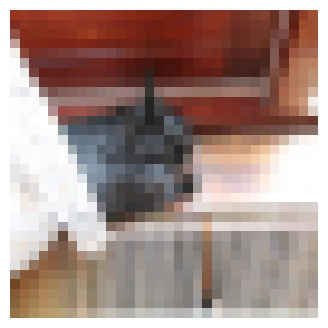

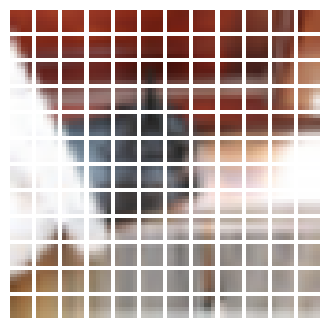

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Layer

*   What is the role of Patch Encoding Layer?

**Solution**

The need to use Patch Encoding Layer comes from using an architecture build for NLP tasks that process sequential inputs (like words in a sentence) and not images. To adapt this architecture for images, this layer divides the image into non-overlapping patches and flattens each patch to a vector, and then it's projected into a fixed dimensional embedding space. This patch embeddings are the analogous as tokens in NLP, and they are combined with positional embeddings to provide spatial information to the model.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

*   What happens in the call function of the PatchEncoder class?

**Solution**

First a vector of positions for every patch is created where each patch has an integer assigned from 0 to num_patches-1. Then the patches are projected into another dimensional space and we add the embeding positions to this encoding vector. Therefore this function is computing the embedding vector of a path when it's called.

## Building the ViT Model

*   We will use the MultiHeadAttention layer as self-attention for this implementation
*   PS: There are many changes to the original paper for ease of execution

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

*   Explain the execution of the ViT model. What is the sequence of operations?
*   What is skip connection? Why is it needed?

**Solution**

- Explain the execution of the ViT model. What is the sequence of operations?

First of all the model receives the input and data augmentation is performed as Transformers needs a very big amount of data to be trained. After that, the patches of this data are created and then we compute the embedding vectors of this images which contains informetion about the images projected to the latent space and also information about the positional encoding. Then we enter in a for loop over all the transformers units we have in our model. In each of them first the input is normalized, after that it goes over a MultiHeadAttention layer which compute diferent atention outputs, then we use a skip connection between the conection before going throught the MultiHeadAttention layer and the output of this one. Then this skip connection is normalized and passes thought an MLP and finally the output is another skip connection between the layer befor the MLP and the result of MLP, this process is done over and over until all transformer layers have been aplied. Finally, this tensor is normalized and flattened and drop out technite is used over them, ant the an MLP is used for classification and give an output as prediction.

- What is skip connection? Why is it needed?

Skip connections are shorcuts that bypasses some layers of the network, adding the output of one layer to another output of another layer deeper in the network. This helps to avoid the problem of vanishing gradients in deep networs. The problem of vanishing gradients is that were there are networks with a lot of layers, the gradient is very small when it arraives to the first layers, there fore they are not able to learn, with this techique this problema can be solve as we allow the gradient to propagate better. Additonaly, it can be demostrated that a network can learn exactly the same parameters without and with skip connections, therefore adding skip connections allows the model to performe better as you are expanding the model, but with a computational cost.

*   What is self-attention?
*   What is the problem in using global self-attention?
*   What can be used instead of global self-attention?

**Solution**

- What is self-attention?

Self-attention is the mechanism used by Transformers that enables them to attend to all other elements in the sequence when computing their representation. The attention is computed using three matrices Q, K and V. The matrix Q referes to the queries the K the keys and de V the values ($d_k$ is the dimensionality K). The idea is that the similarity matching between queries and keys gives the weights that their corresponding value adds. In other words, the self-attention is the weighted sum of the values where the similarity matching between queries and keys are the weights.

$\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V$

- What is the problem in using global self-attention?

Global self-attention is a very powerful but also very computationaly expensive. Every token, or in this case patch, has to be compered to all other ones. Meaning that the number of comparations is $O(n^2)$ for a sequence of length n, additonally it has also the memory drawback. Additionaly a lot of times, parts of the sequence that are far away of the one we are looking don't have any influence on it but we are till computing it, this drawback is usually seen in very large sequences.


- What can be used instead of global self-attention?

There are other methods as could be Local Attention, where each element only looks their neighboors in a determined window. This reduces the computationaly cost to $O(n)$, it's true that therefore very spaciated relations will no be capted, but if we know we are working with this type of data, we can either increase the window size to one that works well or also work with the global self-attention mechanism.


## Training the ViT Model

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 110s 422ms/step - accuracy: 0.0285 - loss: 4.8929 - top-5-accuracy: 0.1108 - val_accuracy: 0.0998 - val_loss: 4.0024 - val_top-5-accuracy: 0.2914
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 407ms/step - accuracy: 0.0815 - loss: 4.0662 - top-5-accuracy: 0.2571 - val_accuracy: 0.1470 - val_loss: 3.6474 - val_top-5-accuracy: 0.3884
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 407ms/step - accuracy: 0.1122 - loss: 3.8038 - top-5-accuracy: 0.3291 - val_accuracy: 0.1760 - val_loss: 3.4807 - val_top-5-accuracy: 0.4346
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.1426 - loss: 3.6032 - top-5-accuracy: 0.3951 - val_accuracy: 0.2136 - val_loss: 3.2411 - val_top-5-accuracy: 0.4964
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.1703 - loss: 3.4610 - top-5-accuracy: 0.4352 - val_accuracy: 0.2372 - val_loss: 3.1018 - val_top-5-accuracy: 0.5292
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 396ms/step - accuracy: 0.1971 

### Creating history plots

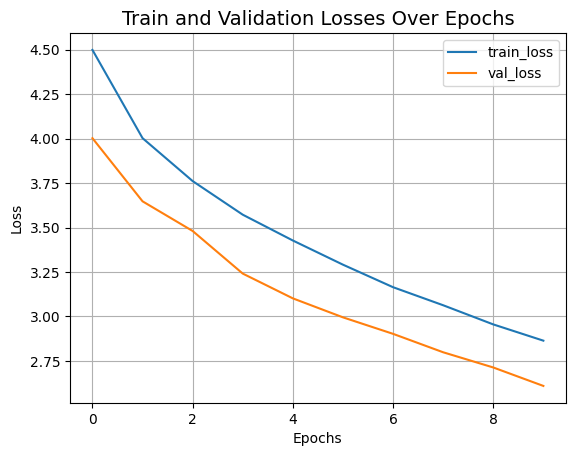

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Evaluating the trained ViT transformer

In [ ]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3603 - loss: 2.5349 - top-5-accuracy: 0.6617
Test loss: 2.55
Test accuracy: 35.68%
Test top 5 accuracy: 65.32%


# Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:
*   Start with an image.
*   Shift the image in diagonal directions.
*   Concat the diagonally shifted images with the original image.
*   Extract patches of the concatenated images.
*   Flatten the spatial dimension of all patches.
*   Layer normalize the flattened patches and then project it.

More details about the implementation can be read from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1)

![image](https://i.imgur.com/bUnHxd0.png)

---
*   Implement a shiftedpatchtokenizer class
*   The class should implement the __init__() and call() functions
*   Implement left-up, right-up, left-down and right-down shift operations


In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size,
        patch_size,
        num_patches,
        projection_dim,
        epsilon=1e-6,
    ):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=epsilon)

    def crop_shift_pad(self, images, mode):
        # Define cropping and shifting parameters
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:  # "right-down"
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop and pad images
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        images = tf.concat(
            [
                images,
                self.crop_shift_pad(images, mode="left-up"),
                self.crop_shift_pad(images, mode="left-down"),
                self.crop_shift_pad(images, mode="right-up"),
                self.crop_shift_pad(images, mode="right-down"),
            ],
            axis=-1,
        )

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        flat_patches = self.flatten_patches(patches)
        tokens = self.layer_norm(flat_patches)
        tokens = self.projection(tokens)

        return tokens, patches

*   Visualize the patches for a random image

ORIGINAL


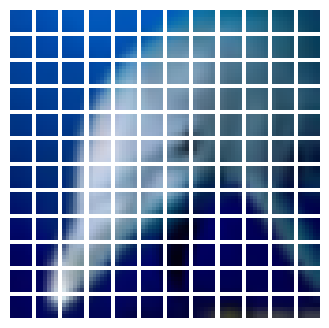

LEFT-UP


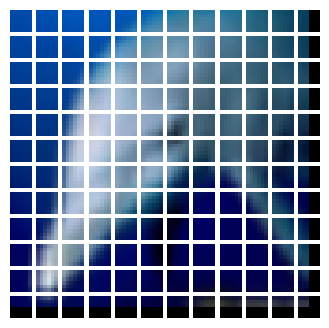

LEFT-DOWN


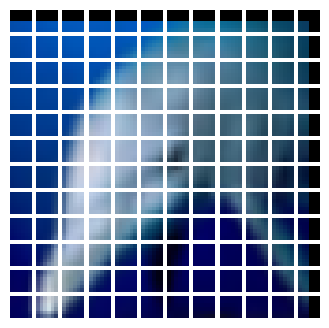

RIGHT-UP


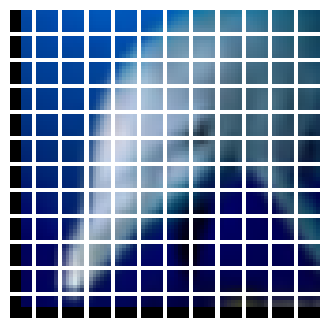

RIGHT-DOWN


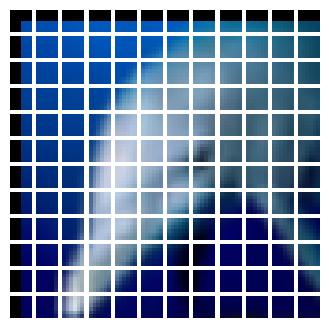

In [ ]:
# solution

import matplotlib.pyplot as plt
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.cast(
    tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size)),
    dtype="float32",
)


# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(image_size, patch_size, num_patches, projection_dim)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (patch_size, patch_size, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Build the ViT model

*   Create the ViT classifier by replacing the Patch Layer with the Shifted Patch Layer

In [ ]:
# solution

def create_vit_classifier_with_spt():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(image_size, patch_size, num_patches, projection_dim)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

*   Compile and train the classifier

In [ ]:
# solution

vit_classifier_with_spt = create_vit_classifier_with_spt()
history_spt = run_experiment(vit_classifier_with_spt)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 442ms/step - accuracy: 0.0305 - loss: 4.9143 - top-5-accuracy: 0.1154 - val_accuracy: 0.1166 - val_loss: 3.9337 - val_top-5-accuracy: 0.3116
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 430ms/step - accuracy: 0.0847 - loss: 4.0713 - top-5-accuracy: 0.2583 - val_accuracy: 0.1534 - val_loss: 3.6541 - val_top-5-accuracy: 0.3906
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 430ms/step - accuracy: 0.1154 - loss: 3.8443 - top-5-accuracy: 0.3252 - val_accuracy: 0.1798 - val_loss: 3.4877 - val_top-5-accuracy: 0.4382
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - accuracy: 0.1365 - loss: 3.6915 - top-5-accuracy: 0.3672 - val_accuracy: 0.2074 - val_loss: 3.3457 - val_top-5-accuracy: 0.4820
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 430ms/step - accuracy: 0.1571 - loss: 3.5623 - top-5-accuracy: 0.4084 - val_accuracy: 0.2284 - val_loss: 3.2046 - val_top-5-accuracy: 0.5110
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.1788 

*   Create the history plot for the new ViT model
*   Evaluate the model using the test set

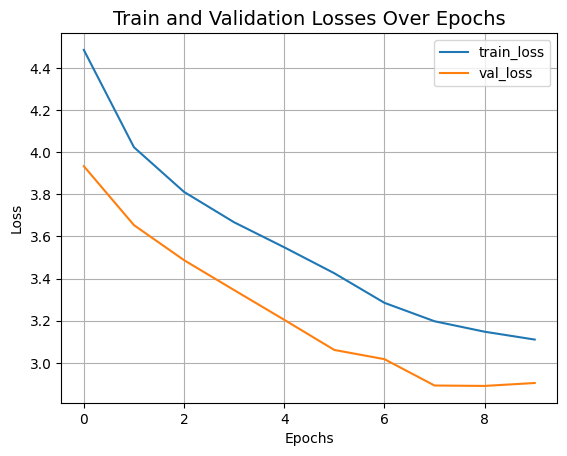

In [ ]:
# solution

plt.plot(history_spt.history["loss"], label="train_loss")
plt.plot(history_spt.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
loss, accuracy, top_5_accuracy = vit_classifier_with_spt.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3452 - loss: 2.5487 - top-5-accuracy: 0.6611
Test loss: 2.56
Test accuracy: 34.76%
Test top 5 accuracy: 65.64%


*   Compute confusion matrix and classification summary of both the models
*   Compare both the models with respect to the computed metrics

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


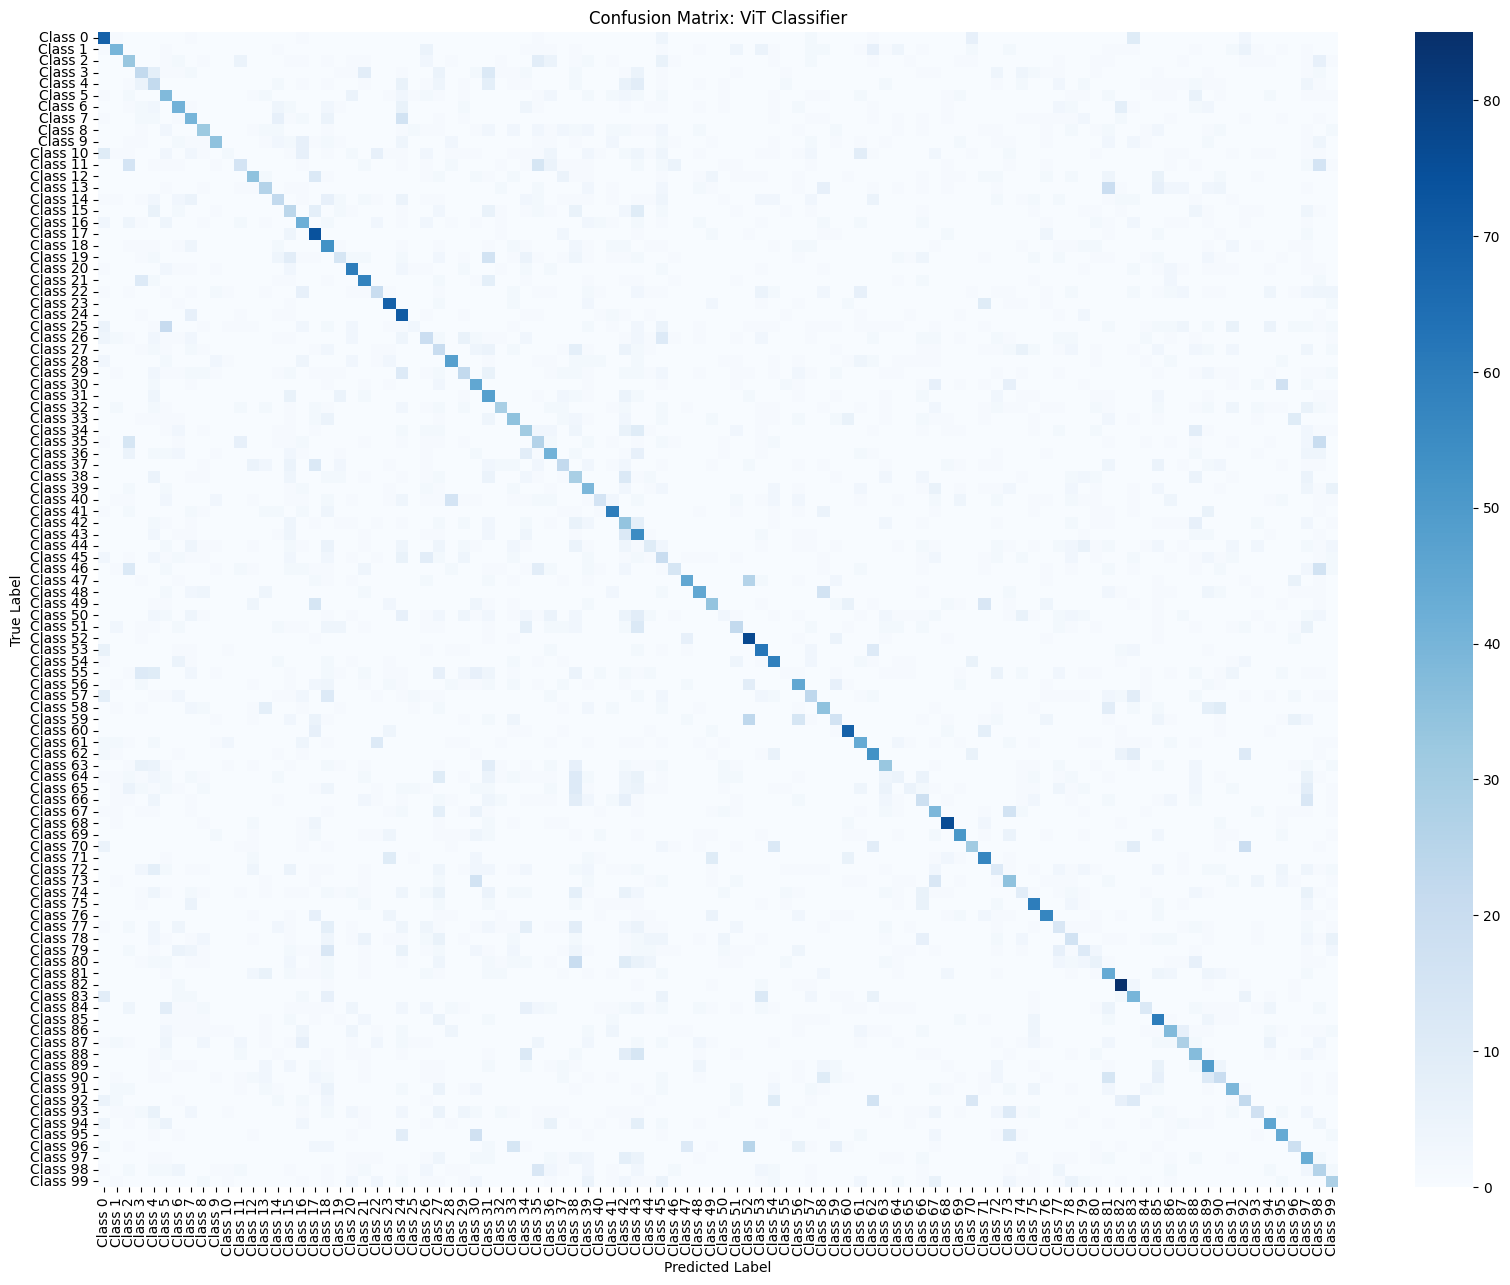

Classification Report for ViT Classifier:
              precision    recall  f1-score   support

     Class 0       0.45      0.69      0.54       100
     Class 1       0.55      0.40      0.46       100
     Class 2       0.26      0.33      0.29       100
     Class 3       0.26      0.22      0.24       100
     Class 4       0.15      0.22      0.18       100
     Class 5       0.26      0.38      0.31       100
     Class 6       0.39      0.41      0.40       100
     Class 7       0.32      0.40      0.35       100
     Class 8       0.43      0.32      0.37       100
     Class 9       0.60      0.35      0.44       100
    Class 10       0.14      0.02      0.04       100
    Class 11       0.32      0.15      0.20       100
    Class 12       0.48      0.35      0.40       100
    Class 13       0.36      0.26      0.30       100
    Class 14       0.31      0.22      0.26       100
    Class 15       0.19      0.24      0.21       100
    Class 16       0.33      0.42      

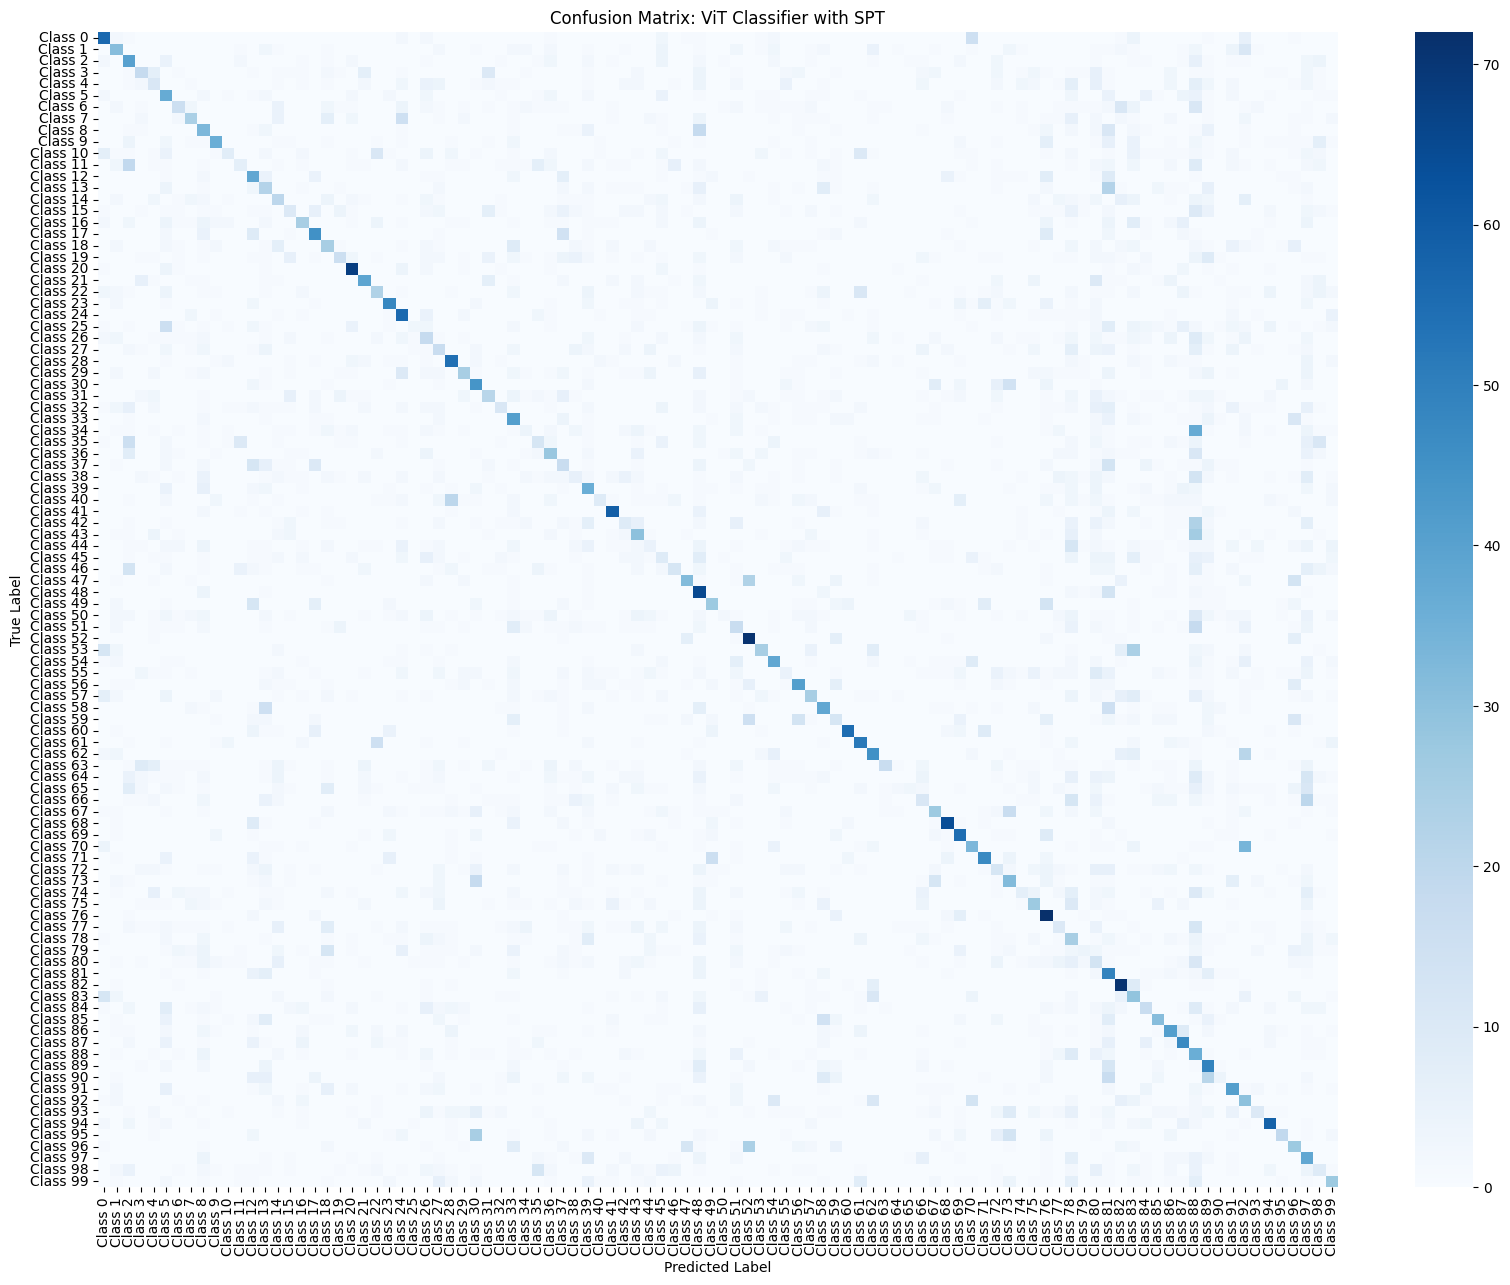

Classification Report for ViT Classifier with SPT:
              precision    recall  f1-score   support

     Class 0       0.45      0.56      0.50       100
     Class 1       0.31      0.31      0.31       100
     Class 2       0.25      0.40      0.30       100
     Class 3       0.30      0.18      0.22       100
     Class 4       0.16      0.11      0.13       100
     Class 5       0.21      0.37      0.27       100
     Class 6       0.31      0.16      0.21       100
     Class 7       0.41      0.24      0.30       100
     Class 8       0.22      0.33      0.26       100
     Class 9       0.56      0.36      0.44       100
    Class 10       0.31      0.08      0.13       100
    Class 11       0.23      0.07      0.11       100
    Class 12       0.25      0.38      0.30       100
    Class 13       0.15      0.22      0.18       100
    Class 14       0.20      0.20      0.20       100
    Class 15       0.20      0.10      0.13       100
    Class 16       0.38      0

In [ ]:
# solution

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

def evaluate_model(model, x_test, y_test, model_name="Model"):

    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert logits to class labels

    class_names = [f"Class {i}" for i in range(len(np.unique(y_test)))]

    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    class_report = classification_report(y_test, y_pred_classes, target_names=class_names)

    plt.figure(figsize=(20, 15))
    sns.heatmap(
        conf_matrix,
        annot=False,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print(f"Classification Report for {model_name}:")
    print(class_report)

evaluate_model(vit_classifier, x_test, y_test, model_name="ViT Classifier")
evaluate_model(vit_classifier_with_spt, x_test, y_test, model_name="ViT Classifier with SPT")


**Solution**

Both models are learning how to classify the classes, as in the classification matrix we can see a well-defined diagonal. However, some of the classes gave their color very soft, meaning that the weight of the classes is spread among all other classes with misclassifications, while others are well predicted. Still, there is a clear diagonal. From the classification report, we can see what I just mentioned earlier: some classes have much higher accuracy than others. On average, we can see that the normal model without the shifted patch tokenizer is working better. This is probably because we are performing very few epochs, and transformers need a lot of epochs to understand the locality properties of an image. So, probably, if we perform this training until both models converge, the shifted patch tokenizer would lead to better results than the vanilla model.

*   Compare DeiT with ViT.
*   What are the differences in both the architectures.
*   What is one limitation of ViT that is overcome with a DeiT?

**Solution**



- Comparison and differences

Both models divide the images into patches, flatten them, and finally perform a linear embedding before feeding them into the Transformer encoder, which is the same for both. The key difference is how they are trained. While ViT requires large-scale datasets to perform well due to a lack of inductive biases like locality and translation equivariance, DeiT achieves competitive performance on smaller datasets like ImageNet by employing training techniques specifically optimized for data efficiency. This is because DeiT introduces a novel token-based distillation mechanism, where a 'distillation token' interacts with other tokens via self-attention. This helps the model learn effectively from teacher networks (either CNNs or other transformers).

- Limitations

ViT struggles to generalize well on datasets of insufficient size due to its minimal inductive biases. DeiT overcomes this limitation through the distillation token, which enables it to learn inductive biases from teacher networks.

*   What is a SWIN Transformer?
*   How is it different from DeiT and ViT?

**Solution**

The Swin Transformer is a Shifted Window Transformer. This model builds hierarchical
feature maps by merging image patches in deeper
layers and has linear computation complexity to input image size
due to computation of self-attention only within each local window. It can thus serve as a general-purpose backbone for both image classification and dense recognition tasks. In contrast, DeiT and ViT produce feature maps of a single low resolution and have quadratic computation complexity to input image size due to computation of self-attention globally. [1]

[1] Training data-efficient image transformers & distillation through attention

*   What is distillation?
*   Explain the distillation used in DeiT
*   What is its significance? Why do we need distillation?

**Solution**

Distillation is a training approach where a teacher (a larger network) helps a student (a smaller and more efficient network) to learn. In this process, the student tries to simulate the behavior of the teacher. Distillation was originally proposed to compress knowledge from a large model into a smaller one by using the teacher's output logits as soft labels for the student. However, in DeiT, token-based distillation takes a different approach. It adds a distillation token to the input sequence alongside the standard class token and patch embeddings. This distillation token interacts with the other tokens through the self-attention mechanism of the transformer. This approach is significant because it allows the transfer of inductive biases via distillation, enabling the model to perform well even with smaller datasets.

*   Which is better as a teacher model? A transformer based teacher of a CNN based teacher?

**Solution**

The choice of a teacher depends on the task, but using a CNN as a teacher usually performs better. This is because a CNN allows the student to learn inductive biases, such as locality, more effectively and quickly than a transformer, as CNNs are inherently designed with these inductive biases. Moreover, training a CNN is less costly than training a transformer, making the process of training the teacher more efficient and less expensive.


---

# **End of P10: Vision Transformers**

This notebook is part of **Deliverable 5**

Deadline for Deliverable 5 (P10 and P11) submission in CampusVirtual is: **Monday, the 16th of December, 2024**
